# 🏦 Bank Customer Churn Dataset Overview

This dataset contains information about a bank's customers and whether they have **churned** (i.e., closed their accounts or left the bank). The primary objective is to analyze customer behavior and build a machine learning model that can predict the likelihood of churn.

## 📄 Dataset Description

Each row represents a single customer, and the columns capture various attributes related to demographics, account activity, and banking behavior.

### 🔑 Key Columns

| Column Name           | Description |
|-----------------------|-------------|
| `CustomerId`          | Unique identifier for each customer |
| `Surname`             | Customer's last name |
| `CreditScore`         | Credit score (higher is better) |
| `Geography`           | Country of residence (e.g., France, Germany, Spain) |
| `Gender`              | Gender of the customer |
| `Age`                 | Age in years |
| `Tenure`              | Number of years the customer has been with the bank |
| `Balance`             | Account balance in dollars |
| `NumOfProducts`       | Number of bank products the customer is using |
| `HasCrCard`           | Whether the customer has a credit card (1 = Yes, 0 = No) |
| `IsActiveMember`      | Whether the customer is active (1 = Active, 0 = Inactive) |
| `EstimatedSalary`     | Estimated annual salary in dollars |
| `Exited`              | **Target variable**: 1 = Customer churned, 0 = Customer stayed |

### 📚 Importing Required Python Libraries

In this section, we import the key Python libraries required for data analysis, visualization, and machine learning.

- **pandas, numpy**: Data manipulation and numerical operations  
- **matplotlib, seaborn**: Data visualization  
- **scikit-learn**: Preprocessing, model training, evaluation  
- **RandomForest**: Ensemble-based machine learning algorithms  
- **warnings**: To suppress unnecessary warnings

These libraries will support our entire workflow from data preprocessing to model evaluation.

In [1]:
# Basic data handling
import pandas as pd
import numpy as np

import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning - preprocessing and models
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from xgboost import XGBClassifier

import mlflow
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer

import joblib
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import YeoJohnsonTransformer, PowerTransformer

# Utility
import warnings
warnings.filterwarnings("ignore")

In [2]:
os.environ['MLFLOW_TRACKING_URI'] = 'http://localhost:5001/'

### 🔍 Exploratory Data Analysis (EDA)

In this section, we will perform exploratory data analysis to understand the structure, quality, and patterns in the dataset. The main goals of EDA are:

- 📏 Understanding data types, missing values, and distributions
- 🧮 Summarizing key statistics
- 📊 Visualizing feature distributions and relationships
- 🧠 Identifying potential correlations with the target variable (`Exited`)

These insights will help us make informed decisions during preprocessing and model selection.

We will begin with a general overview of the dataset, then move on to detailed visual analysis of numerical and categorical features.

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/erkansirin78/datasets/refs/heads/master/Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### 🧹 Dropping Unnecessary Columns

Some columns in the dataset do not contribute meaningful information to the model, such as identifiers or highly correlated/redundant features.

In this step, we will remove the following columns:

- `CustomerId`: Unique identifier, not predictive
- `Surname`: Name is unlikely to impact churn
- `RowNumber`: Row index, not a feature

Removing these columns helps reduce noise and prevent data leakage.

In [4]:
df.drop(columns=["CustomerId","Surname","RowNumber"], inplace=True)
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

### 🧩 Missing Values Analysis

After checking for missing values in the dataset, we confirmed that there are **no null or missing entries** in any of the columns.

This ensures that no imputation or data cleaning is required for handling missing data, and we can proceed directly with feature analysis and modeling.

In [5]:
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### 📊 Feature Distribution Observations

- **CreditScore** appears to follow an approximately normal distribution, which is suitable for most models without transformation.
- **Age** is slightly skewed. Some transformations (e.g., log, Box-Cox, or standardization) may help in approximating a normal distribution.
- **Balance** shows a high concentration of values around a specific point (likely many zeros or near-zero values). Applying transformations might improve its distribution.
- **NumOfProducts**, **HasCrCard**, and **IsActiveMember** appear to be categorical in nature, despite being encoded as numerical values. These should be treated accordingly during preprocessing (e.g., as categorical features or one-hot encoded if needed).

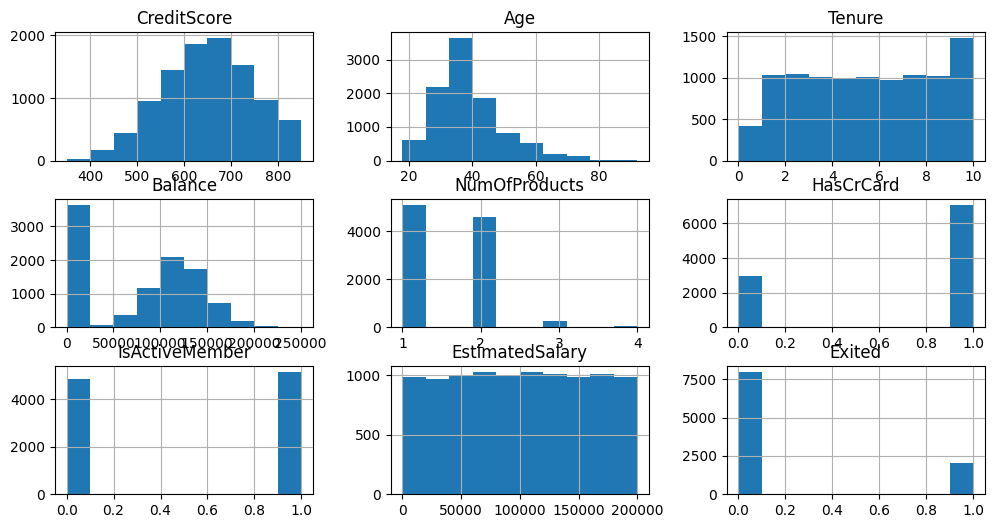

In [6]:
df.select_dtypes(include=["int64", "float64"]).hist(figsize=(12,6))
plt.show()

### 📈 Correlation & Statistical Summary Observations

- Based on the correlation analysis, we did not observe any features with visually strong or problematic multicollinearity. Most variables appear to have low-to-moderate correlation with each other and with the target variable (`Exited`).
  
- According to the `.describe()` summary statistics, the `Age` feature may contain potential outliers, as its maximum value is significantly higher compared to the mean and the 75th percentile. Further investigation and possible outlier treatment may be necessary.

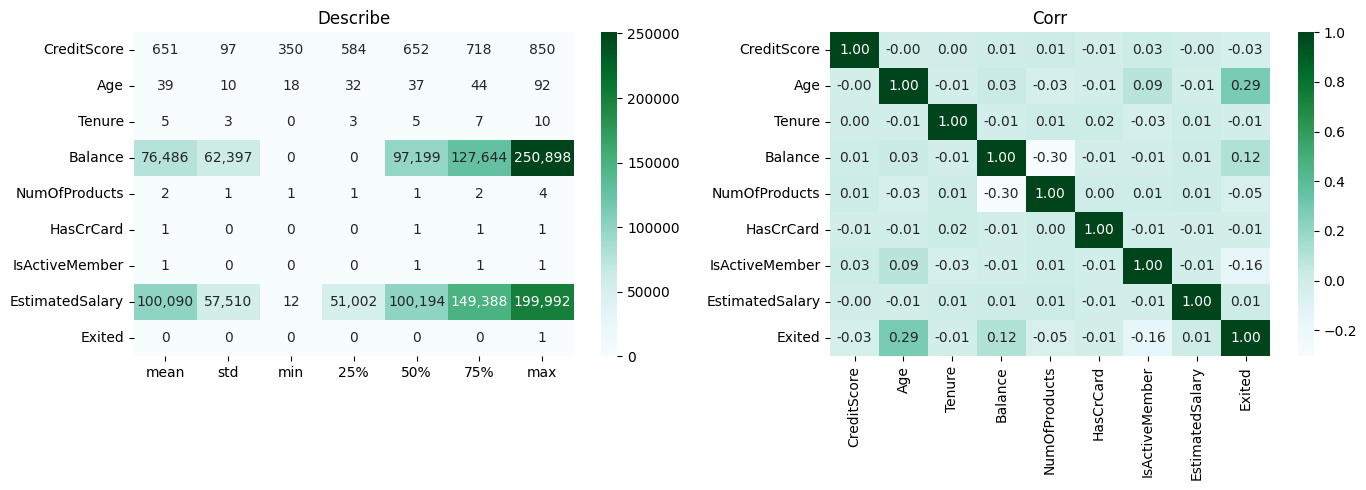

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(df.describe().T.drop(columns=["count"]), annot=True, fmt=",.0f", cmap="BuGn", ax=axes[0])
axes[0].set_title("Describe")

sns.heatmap(df.select_dtypes(include=["int64", "float64"]).corr(), annot=True, fmt=",.2f", cmap="BuGn", ax=axes[1])
axes[1].set_title("Corr")

plt.tight_layout()

### 📊 Categorical Feature Analysis with Respect to the Target Variable

- When examining product ownership, we observe that customers with **3 or more products** have an extremely high churn rate — **approximately 88%** of them have exited the bank.
  
- Beyond product ownership, analyzing customer **activity status** reveals notable differences. In particular, among customers with **only 1 product**, there is a significant gap in churn behavior between **active** and **inactive** members.

In [8]:
df["IsActiveMemberLabeled"] = df["IsActiveMember"].map({0: "Inactive", 1: "Active"})

In [9]:
summary = df.groupby(["NumOfProducts","IsActiveMemberLabeled"])["Exited"].agg(["sum","count","mean"])
summary.rename(columns={"sum":"Churned","count":"Total","mean":"ChurnRate"}).reset_index()

,NumOfProducts,IsActiveMemberLabeled,Churned,Total,ChurnRate
0,1,Active,485,2563,0.189231
1,1,Inactive,924,2521,0.366521
2,2,Active,136,2446,0.055601
3,2,Inactive,212,2144,0.098881
4,3,Active,85,113,0.752212
5,3,Inactive,135,153,0.882353
6,4,Active,29,29,1.000000
7,4,Inactive,31,31,1.000000


### 🧱 Binning on Categorical Features

- When examining the number of observations for customers with **3 or more products**, we found that they represent only **about 3–4% of the entire dataset**.
  
- To reduce sparsity and improve model generalization, it may be beneficial to **bin this feature**, grouping all values **greater than or equal to 2** into a single category (e.g., "2+").

In [10]:
def num_of_products_change(value):
    if value >= 2:
        return "2+"
    else:
        return "1"

df["NumOfProducts_"] = df["NumOfProducts"].apply(num_of_products_change)

In [11]:
df["NumOfProducts_"].value_counts(normalize=1)

NumOfProducts_
1     0.5084
2+    0.4916
Name: proportion, dtype: float64

### 📏 Outlier Treatment for the Age Variable

The `Age` feature shows signs of potential outliers:

- According to the summary statistics, **75% of the customers are aged 44 or younger**, while the **maximum age is 92**.
- This suggests the presence of extreme values in the upper tail of the distribution.

To reduce the influence of these outliers and improve model stability, we will apply an appropriate **censoring or capping strategy** (e.g., using the IQR method or upper quantile threshold) to limit the range of the `Age` variable.

In [12]:
outlier = Winsorizer(capping_method = 'iqr',
                    tail = 'both',
                    fold = 1.5,
                    add_indicators = True,
                    variables = ["Age"])

In [13]:
df["Age_censored"] = outlier.fit_transform(df)["Age"]

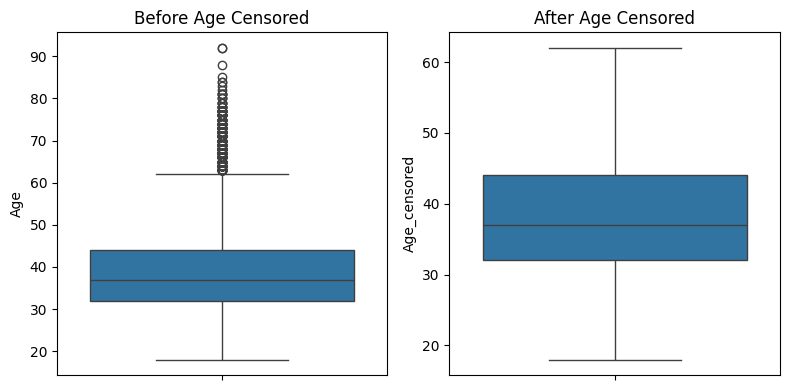

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.boxplot(df["Age"], ax=axes[0])
axes[0].set_title("Before Age Censored")

sns.boxplot(df["Age_censored"], ax=axes[1])
axes[1].set_title("After Age Censored")

plt.tight_layout()

### 📊 Visualization of Other Categorical Features

- When analyzing the `Gender` feature, we observe that **approximately 25% of female customers** have churned, compared to **only 16% of male customers**. This indicates that female customers are relatively more likely to leave the bank.

- In terms of `Geography`, **Germany stands out** with the highest churn rate — around **32%** of customers from Germany have exited. This suggests that location may play a significant role in churn behavior and should be considered during modeling.

In [15]:
df.groupby("Gender")["Exited"].mean()

Gender
Female    0.250715
Male      0.164559
Name: Exited, dtype: float64

In [16]:
df.groupby("Geography")["Exited"].mean()

Geography
France     0.161548
Germany    0.324432
Spain      0.166734
Name: Exited, dtype: float64

### 🤖 Machine Learning Model Development

Before training the model, we will perform the following preprocessing steps to prepare the data:

- **Standardization of numerical features**: Numerical variables will be scaled using standardization (zero mean and unit variance) to ensure that all features contribute equally to the model.

- **Encoding of categorical features**: Categorical variables will be transformed using suitable encoding techniques (e.g., one-hot encoding or label encoding) to convert them into numerical format.

- **Handling class imbalance**: Since the target variable (`Exited`) is imbalanced, we will apply the `class_weight='balanced'` parameter during model training. This will help the model better learn the minority class (churned customers) and prevent bias toward the majority class.

After these steps, we will split the data using an **75/25 train-test ratio** and proceed to train and evaluate a classification model.

In [17]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,IsActiveMemberLabeled,NumOfProducts_,Age_censored
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Active,1,42
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,Active,1,41
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Inactive,2+,42
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,Inactive,2+,39
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,Active,1,43


In [47]:
categorical_features = ["Geography","Gender"]
numeric_features = ["Age_censored","EstimatedSalary","Balance"]
model_features = ["Age_censored","EstimatedSalary","Balance","Tenure","Geography","Gender","NumOfProducts","IsActiveMember"]

In [48]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num',numeric_transformer, numeric_features),
        ('cat',categorical_transformer, categorical_features)
    ]
)

In [49]:
pipeline = ImbPipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression())
    ]
)

In [50]:
param_grid = [
    {
        'classifier': [LogisticRegression(class_weight='balanced', random_state=42)],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs']
    },
    {
        'classifier': [RandomForestClassifier(class_weight='balanced', random_state=42)],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [4, 10],
        'classifier__min_samples_split': [2, 5]
    },
    {
        'classifier':[XGBClassifier(random_state=42)],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [4, 10],
    }
]

In [51]:
X = df[model_features]
y = df['Exited']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [53]:
grid_search_cv = GridSearchCV(pipeline, param_grid, cv=5, scoring="recall", n_jobs=-1)
grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age_censored',
                                                                          'EstimatedSalary',
                                                                          'Balance']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Geography',
                                                                          'Gender'])])),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_gr...
                                                       learning_rate=None,
                                                       max_bin=None,
                                                       max_cat_threshold=None,
                                                       max_cat_to_onehot=None,
                                                       max_delta_step=None,
                                                       max_depth=None,
                                                       max_leaves=None,
                                                       min_child_weight=None,
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       multi_strategy=None,
                                                       n_estimators=None,
                                                       n_jobs=None,
                                                       num_parallel_tree=None, ...)],
                          'classifier__max_depth': [4, 10],
                          'classifier__n_estimators': [100, 200, 300]}],
             scoring='recall')

In [55]:
grid_search_cv.best_params_

{'classifier': RandomForestClassifier(class_weight='balanced', random_state=42),
 'classifier__max_depth': 4,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 100}

In [56]:
y_pred = grid_search_cv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1593
           1       0.38      0.72      0.50       407

    accuracy                           0.70      2000
   macro avg       0.64      0.71      0.64      2000
weighted avg       0.80      0.70      0.73      2000



In [57]:
mlflow.create_experiment("BankChurnPrediction")

'1'

In [58]:
mlflow.set_experiment("BankChurnPrediction")

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1747776566099, experiment_id='1', last_update_time=1747776566099, lifecycle_stage='active', name='BankChurnPrediction', tags={}>

In [60]:
with mlflow.start_run():
    grid_search_cv.fit(X_train, y_train)
    best_model = grid_search_cv.best_estimator_
    y_pred = best_model.predict(X_test)

    # Metrics
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Log parameters
    mlflow.log_params(grid_search_cv.best_params_)
    
    # Log metrics
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("f1_score", f1)
    
    mlflow.sklearn.log_model(best_model, "churn_model_pipeline")
    print(f"MLflow run_id: {mlflow.active_run().info.run_id}")

2025/05/21 00:30:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/21 00:30:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run wise-foal-300 at: http://localhost:5001/#/experiments/1/runs/21da1697e7bb4ddd8e15eb728b06a083.
2025/05/21 00:30:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/1.


MLflow run_id: 21da1697e7bb4ddd8e15eb728b06a083


### 💾 Saving the Trained Model

To preserve the best-performing model for future use (e.g., API deployment, batch prediction, or integration with a Streamlit dashboard), we will save it to disk using the `joblib` library.

This allows the trained model to be reloaded later without needing to retrain, ensuring reproducibility and faster inference in production environments.

In [29]:
#joblib.dump(best_rf, "../app/saved_models/01.randomforest_with_churn.pkl")
#joblib.dump(scaler, "../app/saved_models/02.number_encoder.pkl")